Imports
==============================================================================================

In [144]:
%matplotlib inline
import numpy as np
import pandas as pd
from keras.callbacks import TensorBoard, History, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Dropout
from keras.utils import plot_model
from keras.models import Model
from keras.optimizers import Adam
from pathlib import Path
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from evaluation import *
from machineLearningModel import *
from statsmodels.graphics.tsaplots import plot_acf

Configuration
==============================================================================================

In [261]:
# fix random seed for reproducibility
np.random.seed(13)

## net params
num_layers = 4#2#1#4#3#6
num_neurons = 300#50#100#500
batch_size = 100#500#1000
dropout_rate = 0
const_features = ['latitude', 'longitude', 'altitude', 'modules_per_string', 'strings_per_inverter', 'tilt',
                  'azimuth', 'albedo', 'Technology', 'BIPV', 'A_c', 'N_s', 'pdc0', 'gamma_pdc']#, 'SystemID']#15
dyn_features = ['Wind Direction_x', 'Wind Direction_y', 'Total Cloud Cover', 'Low Cloud Cover', 'Medium Cloud Cover',
                'High Cloud Cover', 'Wind Speed', 'Wind Gust', 'Total Precipitation',
                'Snow Fraction', 'Mean Sea Level Pressure', 'DIF - backwards', 'DNI - backwards', 'Shortwave Radiation',
                'Temperature', 'Relative Humidity', 'Hour_x', 'Hour_y', 'Month_x', 'Month_y']#20
#const_features = ['SystemID']
#dyn_features = ['DIF - backwards', 'DNI - backwards', 'Shortwave Radiation', 'Hour_x', 'Hour_y', 'Month_x', 'Month_y']#, 'Temperature', 'Relative Humidity', 'Hour_x', 'Hour_y', 'Month_x', 'Month_y']
target_features = ['power']
drop_features = ['power_pvlib']
act_fct = 'relu'
out_act = 'relu' # linear, relu
loss_fct = 'mae' # mse, mae
optim = 'adam'
metrics = []
history = History()
val_history = History()

## data params
filename = './data/full_data_5_systems.csv'
correlations = []#'pearson', 'spearman', 'kendall']
timesteps = 5#24
method = 'convlstm' # randfor, mlp, lstm, dilated, cnnlstm, convlstm
flat = ['randfor', 'mlp']
if method in flat:
    shape = (len(const_features + dyn_features) + timesteps * (len(dyn_features + target_features)) + 1,)
else:
    #shape = (timesteps + 1, len(const_features + dyn_features))
    shape = (timesteps + 1, len(const_features + dyn_features + target_features))

## training params
pretraining = True
wfvtraining = True
tensorboard = False
callbacks = [history, ModelCheckpoint('best_model.h5', save_best_only=True)]#, verbose=1)] #EarlyStopping(patience=5), 
shuffle = False#True
epochs = 200#50#20
val_split = 1.0/10.0
forecast_horizon = 1#6#3#24
sliding_window = 672#336#8760#672#336#24#8760
dir = './test_results/'
if not os.path.exists(dir):
    os.makedirs(dir)

Data Preprocessing
==============================================================================================

In [230]:
suffix = ''
if method not in flat:
    suffix = '_2D'
pfname = dir + 'preprocessed_data_t-'+str(timesteps)+'_f'+str(shape[0])+suffix+'.csv'
prep = Path(pfname)
if prep.exists():
    print('Loading preprocessed dataset ...')
    pvlib = np.array_split(pd.read_csv(filename, skipinitialspace=True).set_index(['time', 'SystemID']), 5)[-1].power_pvlib
    dataset = pd.read_csv(pfname, skipinitialspace=True)#.set_index(['time', 'SystemID'])
else:
    print('Data preprocessing ...')
    df = pd.read_csv(filename, skipinitialspace=True).set_index(['time', 'SystemID'])#.set_index('time')
    df = np.array_split(df, 5)[-1] ##################################
    pvlib = df.power_pvlib
    dataset = df[const_features + dyn_features + target_features].copy()[:'2017-02-09 10:00:00']

    if method in flat:
        #separate system
        for i in range(1, timesteps + 1):
            for feature in dyn_features + target_features:
                sys.stdout.write("Shifting %i/%i %s                \r" % (i, timesteps, feature))
                sys.stdout.flush()
                dataset[feature + ' t-' + str(i)] = dataset.shift(i)[feature]
        print('Shifting done.                ')

        dataset['forecast_horizon'] = 0
        p = dataset[target_features]
        dataset = dataset.drop(target_features, axis=1)
        for f in target_features:
            dataset[f] = p[f]
        dataset = dataset.dropna()#.reset_index().set_index(['time', 'SystemID'])
        
        sys.stdout.write("Writing to file ...\r")
        sys.stdout.flush()
        dataset.to_csv(pfname, encoding='utf-8')
        print('Writing done.                ')

        if correlations:
            sys.stdout.write('Computing correlations ...\r')
            sys.stdout.flush()
            for corr in correlations:
                sys.stdout.write("Computing %s correlation matrix                \r" % (corr))
                sys.stdout.flush()
                dataset.corr(method=corr).to_csv(dir + corr + '_correlations.csv', encoding='utf-8')
            print('Correlations done.                   ')
    else:
        x = []
        for i in range(timesteps+1, len(dataset)+1):# t-24h dazu?
            d = dataset.iloc[i-timesteps-1:i].copy()
            d.iloc[-1, -len(target_features):] = -1 # oder auf pvlib wert setzen?
            x.append(d.values)
            #x.append(dataset.iloc[i-timesteps-1:i, :-len(target_features)].values)
        x = np.array(x)
        y = dataset[target_features].iloc[timesteps:]
        split = dataset[:('2015-10-12 07:00:00', 4.0)].iloc[timesteps+1:].shape[0]
        trainX, testX = x[:split], x[split:]
        trainY, testY = y.iloc[:split].values, y.iloc[split:].values
        idx = y.iloc[split:].index
        # stimmt bis hier

if method in flat:
    train, test = dataset[:('2015-10-12 06:00:00', 4.0)], dataset[('2015-10-12 07:00:00', 4.0):]
    trainX, trainY = train.iloc[:,:-len(target_features)], train.iloc[:,-len(target_features):]
    testX, testY = test.iloc[:,:-len(target_features)], test.iloc[:,-len(target_features):]
    idx = testX.index.values

Data preprocessing ...


Build Model
==============================================================================================

In [251]:
if method is 'randfor':
    model = RandomForest(10, 0.33, 'mae')#216 0.63 mse
else:
    if tensorboard:
        print('tensorboard activated')
        callbacks.append(TensorBoard(log_dir='./tensorboard', histogram_freq=1, batch_size=batch_size, write_graph=True, write_grads=True, write_images=False))

    if method is 'mlp':
        model = MultiLayerPerceptron(shape, len(target_features), num_layers, num_neurons, loss_fct, optim,
                                     act_fct, out_act, metrics, dropout_rate, dir + 'model.png', batch_size,
                                     epochs, val_split, callbacks, 1, True)
    elif method is 'lstm':
        model = LongShortTermMemory(shape, len(target_features), num_layers, num_neurons, loss_fct, optim,
                                    act_fct, out_act, metrics, dropout_rate, dir + 'model.png', batch_size,
                                    epochs, val_split, callbacks, 1, True)
    elif method is 'dilated':
        model = DilatedConvolution(shape, len(target_features), num_layers, loss_fct, optim,
                                   act_fct, out_act, metrics, dropout_rate, dir + 'model.png', batch_size,
                                   epochs, val_split, callbacks, 1, True)
    elif method is 'cnnlstm':
        model = CNNLSTM(shape, len(target_features), num_layers, num_neurons, loss_fct, optim,
                        act_fct, out_act, metrics, dropout_rate, dir + 'model.png', batch_size,
                        epochs, val_split, callbacks, 1, True)
    elif method is 'convlstm':
        model = ConvLSTM(shape, len(target_features), num_layers, num_neurons, loss_fct, optim,
                         act_fct, out_act, metrics, dropout_rate, dir + 'model.png', batch_size,
                         epochs, val_split, callbacks, 1, True)    

Using ConvLSTM



Training
==============================================================================================

In [252]:
if pretraining:
    X = testX#trainX
    y = testY#trainY

    if shuffle:
        df = pd.DataFrame(np.concatenate((trainX, trainY), axis=1))
        df = df.sample(frac=1).values
        y = pd.DataFrame(df[:, -len(target_features):])
        X = pd.DataFrame(df[:, :-len(target_features)])
    if method is 'cnnlstm':
        X = X.reshape((X.shape[0], 1, shape[0], shape[1]))
    if method is 'convlstm':
        X = X.reshape((X.shape[0], 1, 1, shape[0], shape[1]))
        
    print('Start pretraining ...')    
    model.learn(X, y)

    if method != 'randfor':
        name = './saved_models/pretrained_t-'+str(timesteps)+'_f'+str(shape[0])+'_e'+str(epochs)+'_b'+str(batch_size)+'_sys'+str(4)
        # serialize model to JSON
        model_json = model.model.to_json()
        with open(name + ".json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.model.save_weights(name + ".h5")
        print("Saved model to disk")

Start pretraining ...
Train on 10501 samples, validate on 1167 samples
Epoch 1/200
10501/10501 [==============================] - 9s 818us/step - loss: 743.0574 - val_loss: 187.0720
Epoch 2/200
10501/10501 [==============================] - 4s 378us/step - loss: 314.8308 - val_loss: 171.4720
Epoch 3/200
10501/10501 [==============================] - 4s 350us/step - loss: 297.9740 - val_loss: 139.2103
Epoch 4/200
10501/10501 [==============================] - 4s 375us/step - loss: 289.0843 - val_loss: 150.9119
Epoch 5/200
10501/10501 [==============================] - 4s 341us/step - loss: 286.1437 - val_loss: 134.4830
Epoch 6/200
10501/10501 [==============================] - 3s 330us/step - loss: 272.1428 - val_loss: 120.3452
Epoch 7/200
10501/10501 [==============================] - 3s 332us/step - loss: 272.9939 - val_loss: 141.5322
Epoch 8/200
10501/10501 [==============================] - 3s 326us/step - loss: 281.3717 - val_loss: 132.7908
Epoch 9/200
10501/10501 [================

KeyboardInterrupt: 

In [253]:
# save pretrained model for different testing
model_backup = model

In [254]:
# load best
model.model.load_weights('best_model.h5')

In [255]:
#model = model_backup

Walk-Forward Validation
==============================================================================================

In [262]:
model.epochs = 5
model.verbose = 0
model.callbacks = [val_history] 
model.validation_split = 0.0

predictions = []
pred_err = []
length = len(testX)# - forecast_horizon - 1
trainset = []
trainy = []
perr = -1
for i in range(length):
    if i == sliding_window + 1:
        model.validation_split = 1.0/10.0
        model.callbacks.append(EarlyStopping(patience=5))
        #model.epochs = 5
    if i > sliding_window + 1 and wfvtraining:
        loss = h.history['loss'][-1]
        val_loss = min(h.history['val_loss'])#[-1]#min()
    else:
        loss = -1
        val_loss = -1

    sys.stdout.write("Walk-Forward Validation %i/%i: %d %d, pred: %d    \r" % (i+1, length, loss, val_loss, perr))
    sys.stdout.flush()
    
    if method in flat:
        # initialize values for lagged power columns
        p = []
        for l in range(1, timesteps + 1):
            p.append(testX.iloc[i:i+1,:]['power t-'+str(l)].values[0])

        ps = []
        ts = []
        ty = []
        for f in range(forecast_horizon):
            # build input vector for future timestep
            t = testX.iloc[i+f:i+1+f,:].copy()
            for l in range(timesteps-1, 1, -1):
                t['power t-' + str(l+1)] = p[l]
                p[l] = p[l-1]
            t['power t-1'] = p[0]
            t['forecast_horizon'] = f
            ts.append(t)
            ty.append(testY.iloc[i+f:i+1+f,:])

            # make prediction for input new vector
            p[0] = model.forecast(t.values).item(0)
            ps.append(p[0])

        pred_err.append((testY.iloc[i:i+forecast_horizon,:].values - ps).flatten())
        perr = pred_err[-1][0]
        
        trainset = trainset + ts
        trainy = trainy + ty
        w = i - sliding_window
        if w >= 0:
            trainset = trainset[forecast_horizon:]
            trainy = trainy[forecast_horizon:]

        if wfvtraining:
            dfX = pd.concat(trainset)
            dfX = dfX[dfX.index.get_level_values(0) <= testX.iloc[i].name[0]]
            dfY = pd.concat(trainy)
            dfY = dfY[dfY.index.get_level_values(0) <= testY.iloc[i].name[0]]

            # train with newly available data
            loss = model.learn(dfX.values, dfY.values)

        predictions.append(pd.DataFrame(ps))
    else:
        # collect predictions
        X = testX[i:i+forecast_horizon,:]
        if method is 'cnnlstm':
            X = X.reshape((X.shape[0], 1, shape[0], shape[1]))
        if method is 'convlstm':
            X = X.reshape((X.shape[0], 1, 1, shape[0], shape[1]))
        p = pd.DataFrame(model.forecast(X))
        predictions.append(p)
        pred_err.append(testY[i:i+forecast_horizon,:] - p)
        perr = pred_err[-1][0]
       
        if wfvtraining:
            w = i - sliding_window
            if w < 0:
                w = 0

            #if w >= 0:
            X = testX[w:i+1]
            if method is 'cnnlstm':
                X = X.reshape((X.shape[0], 1, shape[0], shape[1]))
            if method is 'convlstm':
                X = X.reshape((X.shape[0], 1, 1, shape[0], shape[1]))

            # train with newly available data
            h = model.learn(X, testY[w:i+1])#forecast_horizon? only if y is not zero maybe?
    
prediction = pd.concat(predictions)

if method != 'randfor':
    name = './saved_models/trained_t-'+str(timesteps)+'_f'+str(shape[0])+'_e'+str(epochs)+'_b'+str(batch_size)+'_sys'+str(4)
    # serialize model to JSON
    model_json = model.model.to_json()
    with open(name + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.model.save_weights(name + ".h5")
    print("\nSaved model to disk")

KeyboardInterrupt: 

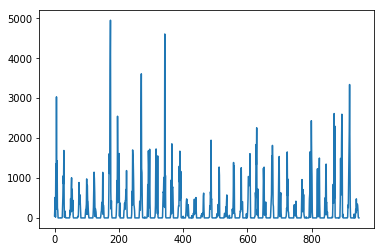

In [263]:
plt.plot(np.abs(pred_err))
plt.show()

Evaluation
==============================================================================================

In [258]:
method = 'pvlib'
data = pd.DataFrame()
for i in range(forecast_horizon):
    data['+'+str(i+1)+'h-prediction'] = np.pad(prediction[:][0][i].values, (i, 0), mode='constant', constant_values=(np.nan,))
    #data['+'+str(i+1)+'h-prediction'] = np.pad(prediction[:][0][i].values, (i, forecast_horizon - i - 1), mode='constant', constant_values=(np.nan,))
data['measured'] = pd.DataFrame(np.array(testY).reshape([len(testY), len(target_features)])).iloc[:,0]
data = data.set_index(pd.MultiIndex.from_tuples(idx)).unstack()#[:-4] [:-2] [:1-forecast_horizon]
data['pvlib'] = pvlib[('2015-10-12 07:00:00', 4.0):('2017-02-09 10:00:00', 4.0)].unstack()[4].reindex(data.index)
print(data)
#print(asdf)
# stimmt bis hier

tmp = pd.DataFrame()
tmp[method] = data[method]
tmp['measured'] = data[('measured', 4.0)]
for i in range(forecast_horizon):
    tmp['+'+str(i+1)+'h-prediction'] = data['+'+str(i+1)+'h-prediction']
data = tmp
data.index = pd.to_datetime(data.index)
data = data.dropna()

m_col = data['measured']
l_col = data[method].dropna()

for horizon in range(1, forecast_horizon + 1):
    name = '+' + str(horizon) + 'h-prediction'
    p_col = data[name]

    walkForwardDailyLoss(m_col, p_col, l_col, method, name)
    scatter_predictions(m_col, p_col, name)

    print('%s test RMSE: %.3f' % (name, math.sqrt(mean_squared_error(m_col, p_col))))
    print('%s test RMSE: %.3f' % (method + ' forecast', math.sqrt(mean_squared_error(m_col, l_col))))
    draw_boxplot(m_col, p_col, l_col, method, name)
    draw_boxplot_monthly(m_col, p_col, l_col, method, name)

    m1, m2 = '2016-07-17 00:00:00', '2016-07-17 23:00:00'
    print('%s nice day RMSE: %.3f' % (name, math.sqrt(mean_squared_error(m_col[m1:m2], p_col[m1:m2]))))
    print('%s nice day RMSE: %.3f' % (method + ' forecast', math.sqrt(mean_squared_error(m_col[m1:m2], l_col[m1:m2]))))
    draw_boxplot(m_col, p_col, l_col, method, name, m1, m2)

    plot_timeseries(m_col, p_col, l_col, method, name, end='2015-10-19 07:00:00')
    plot_timeseries(m_col, p_col, l_col, method, name, start='2017-02-02 10:00:00')
    plot_timeseries(m_col, p_col, l_col, method, name, start=m1, end=m2)
    plot_timeseries(m_col, p_col, l_col, method, name)
    plot_timeseries(m_col, p_col, None, method, name)

    draw_histogram(p_col, m_col, name)

                    +1h-prediction measured        pvlib
                                 4        4             
2015-10-12 07:00:00     173.176285    226.0   983.729736
2015-10-12 08:00:00     665.790833    889.0  2728.356391
2015-10-12 09:00:00    1644.910645   2285.0  4321.887463
2015-10-12 10:00:00    3577.267822   3800.0  5622.943275
2015-10-12 11:00:00    4625.345703   6120.0  6607.420908
2015-10-12 12:00:00    6304.725586   6861.0  7424.334845
2015-10-12 13:00:00    6673.945312   4424.0  6993.044451
2015-10-12 14:00:00    3657.757812   4120.0  5708.656831
2015-10-12 15:00:00    2344.251953   3719.0  4064.829447
2015-10-12 16:00:00    1152.374512   1282.0  2574.562167
2015-10-12 17:00:00       0.000000    194.0   313.640241
2015-10-12 18:00:00       0.000000      0.0     0.000000
2015-10-12 19:00:00       0.000000      0.0     0.000000
2015-10-12 20:00:00       0.000000      0.0     0.000000
2015-10-12 21:00:00       0.000000      0.0     0.000000
2015-10-12 22:00:00       0.000

In [259]:
draw_history(history)
draw_history(val_history, True)
print(val_history.history)

AttributeError: 'History' object has no attribute 'history'

In [260]:
print(data.describe())
print(data.corr(method='pearson'))
print(data.corr(method='spearman'))
print(data.corr(method='kendall'))
data.to_csv(dir + 'predictions.csv', encoding='utf-8')

              pvlib      measured  +1h-prediction
count  11668.000000  11668.000000    11668.000000
mean    1549.927821   1063.940859     1011.649719
std     2226.069714   1923.177158     1817.874512
min        0.000000      0.000000        0.000000
25%        0.000000      0.000000        0.000000
50%        0.000000      0.000000        0.000000
75%     2847.263861   1125.250000     1247.729462
max     9849.600000   8494.000000     8210.255859
                   pvlib  measured  +1h-prediction
pvlib           1.000000  0.791976        0.814031
measured        0.791976  1.000000        0.957696
+1h-prediction  0.814031  0.957696        1.000000
                   pvlib  measured  +1h-prediction
pvlib           1.000000  0.940360        0.907598
measured        0.940360  1.000000        0.946225
+1h-prediction  0.907598  0.946225        1.000000
                   pvlib  measured  +1h-prediction
pvlib           1.000000  0.824358        0.801474
measured        0.824358  1.000000      